In [67]:
#DATASET: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

### Prerequisities

In [7]:
#pd.__version__
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 1000); pd.set_option('display.width', None)


In [8]:
#!pip install scikit-learn pandas numpy scipy  -U
#!pip install tsne umap-learn phate  -U
#!pip install fastcluster  -U


# Loading data

In [9]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Reproducibility

In [10]:
import random
import numpy as np


random_state = 42
random.seed(random_state)
np.random.seed(random_state)

## Data preprocessing


In [11]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [12]:
#if needed
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y = le.fit_transform(df['target'])
# df = df.drop('target', axis=1)

In [13]:
y = df['DEATH_EVENT']
df = df.drop('DEATH_EVENT', axis=1)
df = df.drop('time', axis=1)

In [14]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682


### EDA

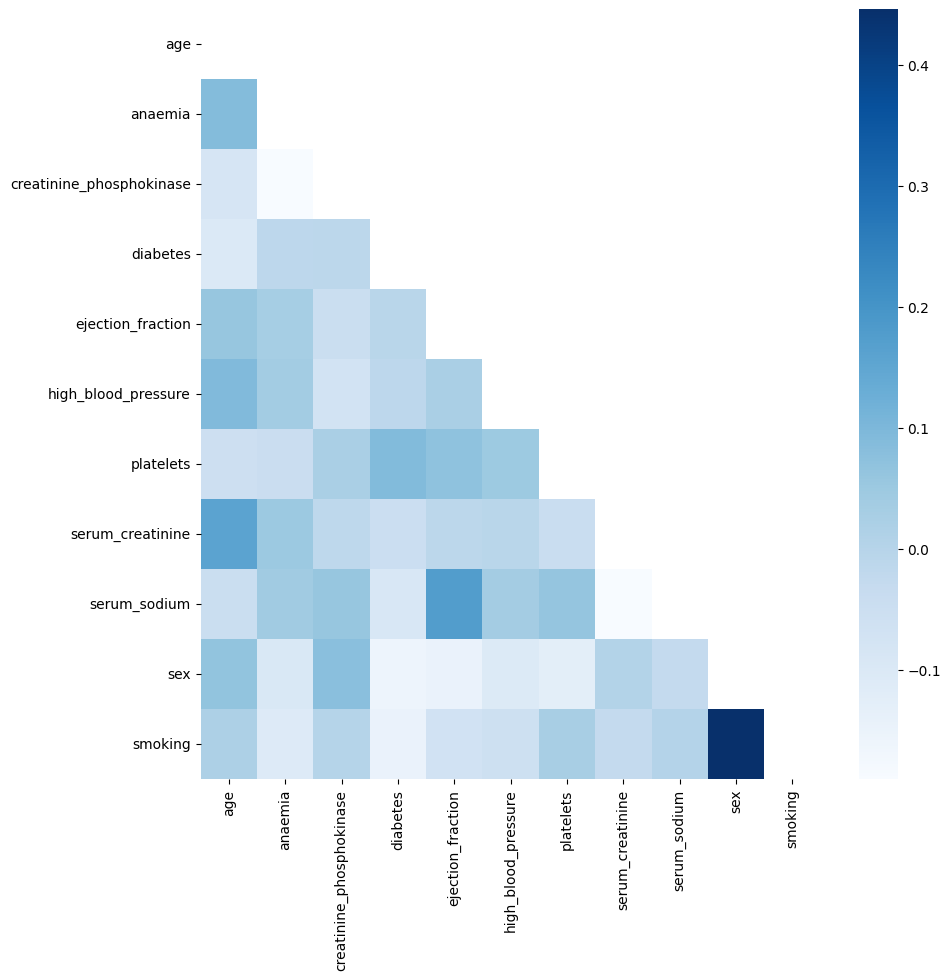

In [15]:
fig = plt.figure(figsize=(10,10))

# applying mask 
mask = np.triu(np.ones_like(df.corr())) 
  
# plotting a triangle correlation heatmap 
ax = sns.heatmap(X.corr(), mask=mask, cmap='Blues') 


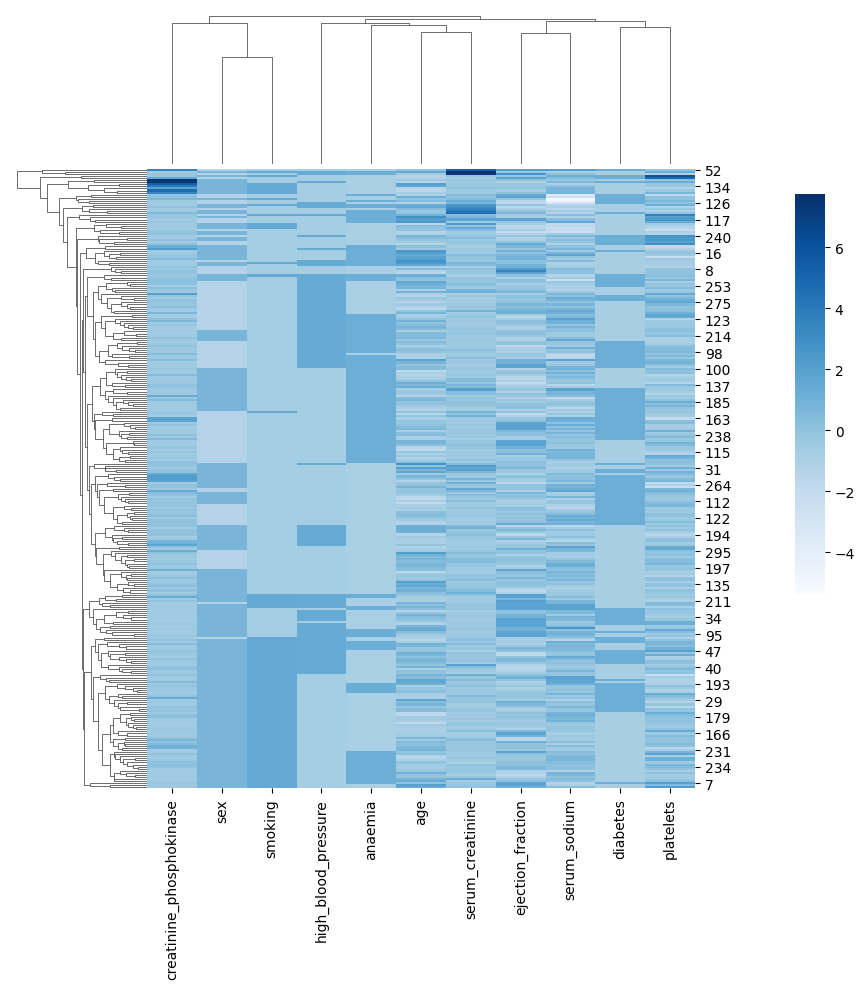

In [16]:
ax = sns.clustermap(X, cmap='Blues')
ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .4, .03, .4))

### Clustering

In [17]:
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [18]:
from sklearn.metrics import *
from sklearn.cluster import MiniBatchKMeans,KMeans,HDBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from scipy.optimize import linear_sum_assignment

methods_clustering=[KMeans, HDBSCAN]

metrics = [adjusted_mutual_info_score, 
           adjusted_rand_score,
           silhouette_score,
           homogeneity_score,
           completeness_score,
           v_measure_score
          ]

hyper_params_MiniBatchKMeans = {
    'n_clusters' : [16],
    'random_state' : [random_state],
}

hyper_params_KMeans = {
    'n_clusters' : [10, 12, 14, 16],
    'n_init': [10],
    'random_state' : [random_state],
}

hyper_params_HDBSCAN = {
    'min_cluster_size' : [10],
    'cluster_selection_epsilon': [2,3,4,5],
}


In [19]:
#filtering out warnings

import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_THREADING_LAYER"] = "GNU"

import warnings
warnings.filterwarnings('ignore')



In [20]:
results=[]


for method in methods_clustering:
    hyper_params = 'hyper_params_' + method.__name__
    print(method.__name__)
    for params in ParameterGrid(eval(hyper_params)):
        print(params)
        est = eval(method.__name__)(**params)
        X_pred = est.fit_predict(X)
        results.append({'method' : method.__name__, 'params' : str(params), 
                        'adjusted_mutual_info_score' : adjusted_mutual_info_score(y, est.labels_),
                        'adjusted_rand_score' : adjusted_rand_score(y, est.labels_),
                        'homogeneity' : homogeneity_score(y, est.labels_),
                        'completeness' : completeness_score(y, est.labels_),
                        'v_measure' : v_measure_score(y, est.labels_),
                        'silhouette_score' : silhouette_score(X, X_pred),
                        'calinski_harabasz_score' : calinski_harabasz_score(X, X_pred),
                        'davies_bouldin_score' : davies_bouldin_score(X, X_pred)
                       })

KMeans
{'n_clusters': 10, 'n_init': 10, 'random_state': 42}
{'n_clusters': 12, 'n_init': 10, 'random_state': 42}
{'n_clusters': 14, 'n_init': 10, 'random_state': 42}
{'n_clusters': 16, 'n_init': 10, 'random_state': 42}
HDBSCAN
{'cluster_selection_epsilon': 2, 'min_cluster_size': 10}
{'cluster_selection_epsilon': 3, 'min_cluster_size': 10}
{'cluster_selection_epsilon': 4, 'min_cluster_size': 10}
{'cluster_selection_epsilon': 5, 'min_cluster_size': 10}


In [21]:
results = pd.DataFrame(results)
results

,method,params,adjusted_mutual_info_score,adjusted_rand_score,homogeneity,completeness,v_measure,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,KMeans,"{'n_clusters': 10, 'n_init': 10, 'random_state...",0.026967,0.023588,0.084074,0.024680,0.038158,0.134217,25.188453,1.791244
1,KMeans,"{'n_clusters': 12, 'n_init': 10, 'random_state...",0.025259,0.018978,0.089774,0.024160,0.038074,0.131126,22.799448,1.748942
2,KMeans,"{'n_clusters': 14, 'n_init': 10, 'random_state...",0.016673,0.010232,0.077920,0.019315,0.030957,0.119496,21.721410,1.749849
3,KMeans,"{'n_clusters': 16, 'n_init': 10, 'random_state...",0.031910,0.015433,0.124950,0.029484,0.047710,0.135167,20.981629,1.639484
4,HDBSCAN,"{'cluster_selection_epsilon': 2, 'min_cluster_...",0.039876,-0.061454,0.039097,0.056559,0.046235,-0.132939,5.880713,3.372055
5,HDBSCAN,"{'cluster_selection_epsilon': 3, 'min_cluster_...",0.039876,-0.061454,0.039097,0.056559,0.046235,-0.132939,5.880713,3.372055
6,HDBSCAN,"{'cluster_selection_epsilon': 4, 'min_cluster_...",0.039876,-0.061454,0.039097,0.056559,0.046235,-0.132939,5.880713,3.372055
7,HDBSCAN,"{'cluster_selection_epsilon': 5, 'min_cluster_...",0.039876,-0.061454,0.039097,0.056559,0.046235,-0.132939,5.880713,3.372055


In [22]:
best_est = results.iloc[results['silhouette_score'].idxmax()]
method = best_est['method']
params = eval(best_est['params'])
est = eval(method)(**params)

In [23]:
from collections import Counter
X_pred = est.fit_predict(X)
#Counter(X_pred)

### TSNE, Phate, UMAP

In [24]:
from sklearn.manifold import TSNE
from umap import UMAP
from phate import PHATE

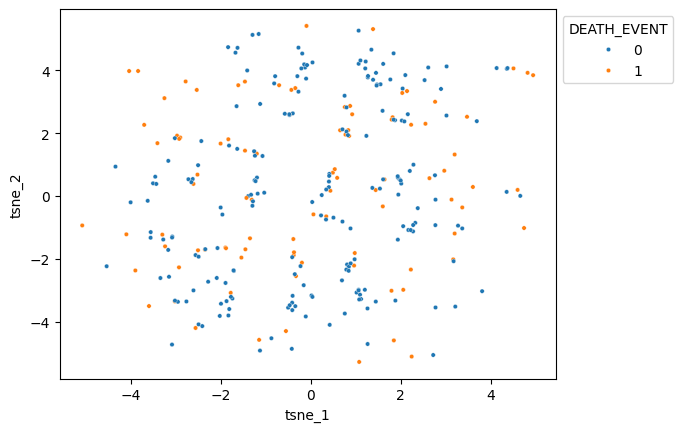

In [25]:
tsne=pd.DataFrame(TSNE(n_components=2, learning_rate='auto',init='random', perplexity=100).fit_transform(X), columns=['tsne_1', 'tsne_2'])
ax = sns.scatterplot(data = tsne, x = "tsne_1", y = "tsne_2", hue=y, s=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Calculating PHATE...
  Running PHATE on 299 observations and 11 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.19 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.18 seconds.
Calculated PHATE in 0.44 seconds.


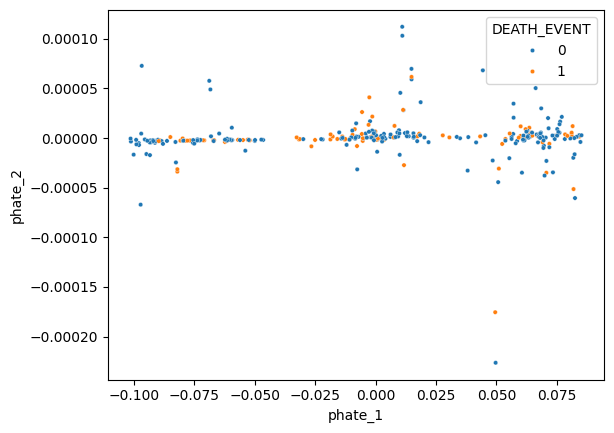

In [26]:
import phate
phate_op = phate.PHATE(knn=20, decay=40, t=150)
data_phate = phate_op.fit_transform(X)
phate_df=pd.DataFrame(data_phate, columns=['phate_1', 'phate_2'])
sns.scatterplot(data = phate_df, x = "phate_1", y = "phate_2", hue=y, s=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

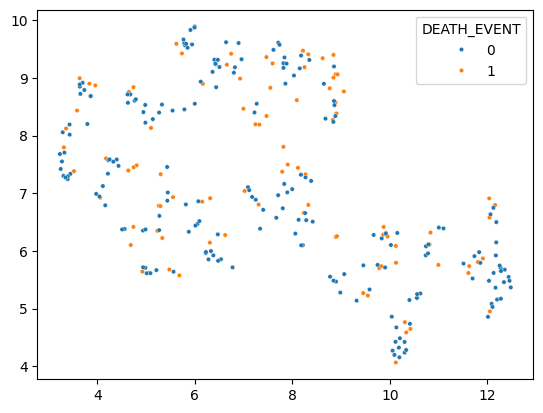

In [27]:
import umap

embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y, s=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Coclustering, biclustering

In [43]:
from sklearn.cluster import SpectralCoclustering
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt


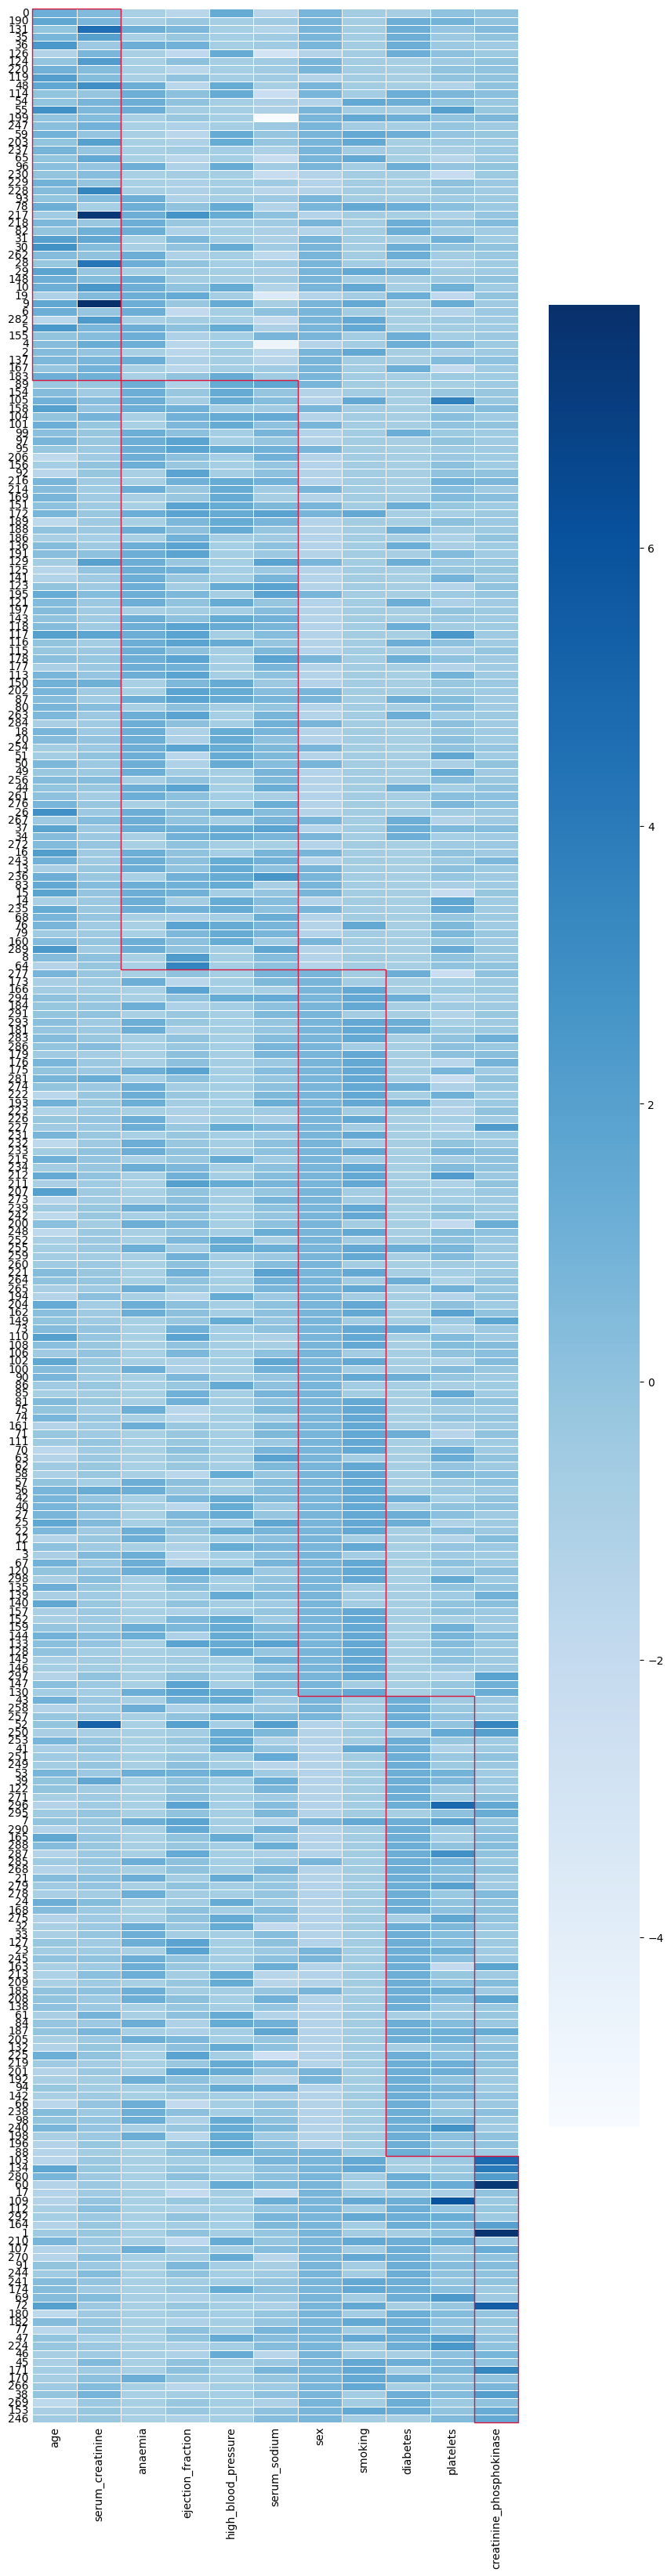

In [48]:
for n_clusters in range(5,6):
    est_cocl = SpectralCoclustering(n_clusters=n_clusters, random_state=0)
    est_cocl.fit(X)
    fit_cocl = X.values[np.argsort(est_cocl.row_labels_)]
    fit_cocl = fit_cocl[:, np.argsort(est_cocl.column_labels_)]
    fit_cocl = pd.DataFrame(fit_cocl, columns=X.columns[np.argsort(est_cocl.column_labels_)], index=X.index[np.argsort(est_cocl.row_labels_)])
    pos_w=[]
    pos_h=[]
    for i in range(len(est_cocl.biclusters_[0])):
        pos_w.append(sum(est_cocl.biclusters_[0][i]))
        pos_h.append(sum(est_cocl.biclusters_[1][i]))


    fig=plt.figure(figsize=(10,40))
    ax = sns.heatmap(fit_cocl, cmap='Blues', linewidths=.5,
                     xticklabels=fit_data.columns, yticklabels=fit_data.index)

    pos_x=0
    pos_y=0
    for i in range(est_cocl.n_clusters):
        pos_w=len([np.argsort(est_cocl.column_labels_)[b]  for b in est_cocl.biclusters_[1]][i])
        pos_h=len([np.argsort(est_cocl.row_labels_)[b]  for b in est_cocl.biclusters_[0]][i])
        ax.add_patch(Rectangle((pos_x, pos_y), pos_w, pos_h, fill=False, edgecolor='crimson', lw=1, clip_on=False))
        pos_x+=pos_w
        pos_y+=pos_h

    ax.tick_params(length=0)
    #fig.savefig('coclust/coclust_{}.png'.format(est.n_clusters), bbox_inches='tight')
    #plt.close(fig)
    plt.show()

In [49]:
from sklearn.cluster import SpectralBiclustering


In [50]:
# fit_data = df2.values[np.argsort(est.row_labels_)]
# fit_data = fit_data[:, np.argsort(est.column_labels_)]
# fit_data = pd.DataFrame(fit_data, columns=df2.columns[np.argsort(est.column_labels_)], index=df2.index[np.argsort(est.row_labels_)])
# from matplotlib.patches import Rectangle


4 3


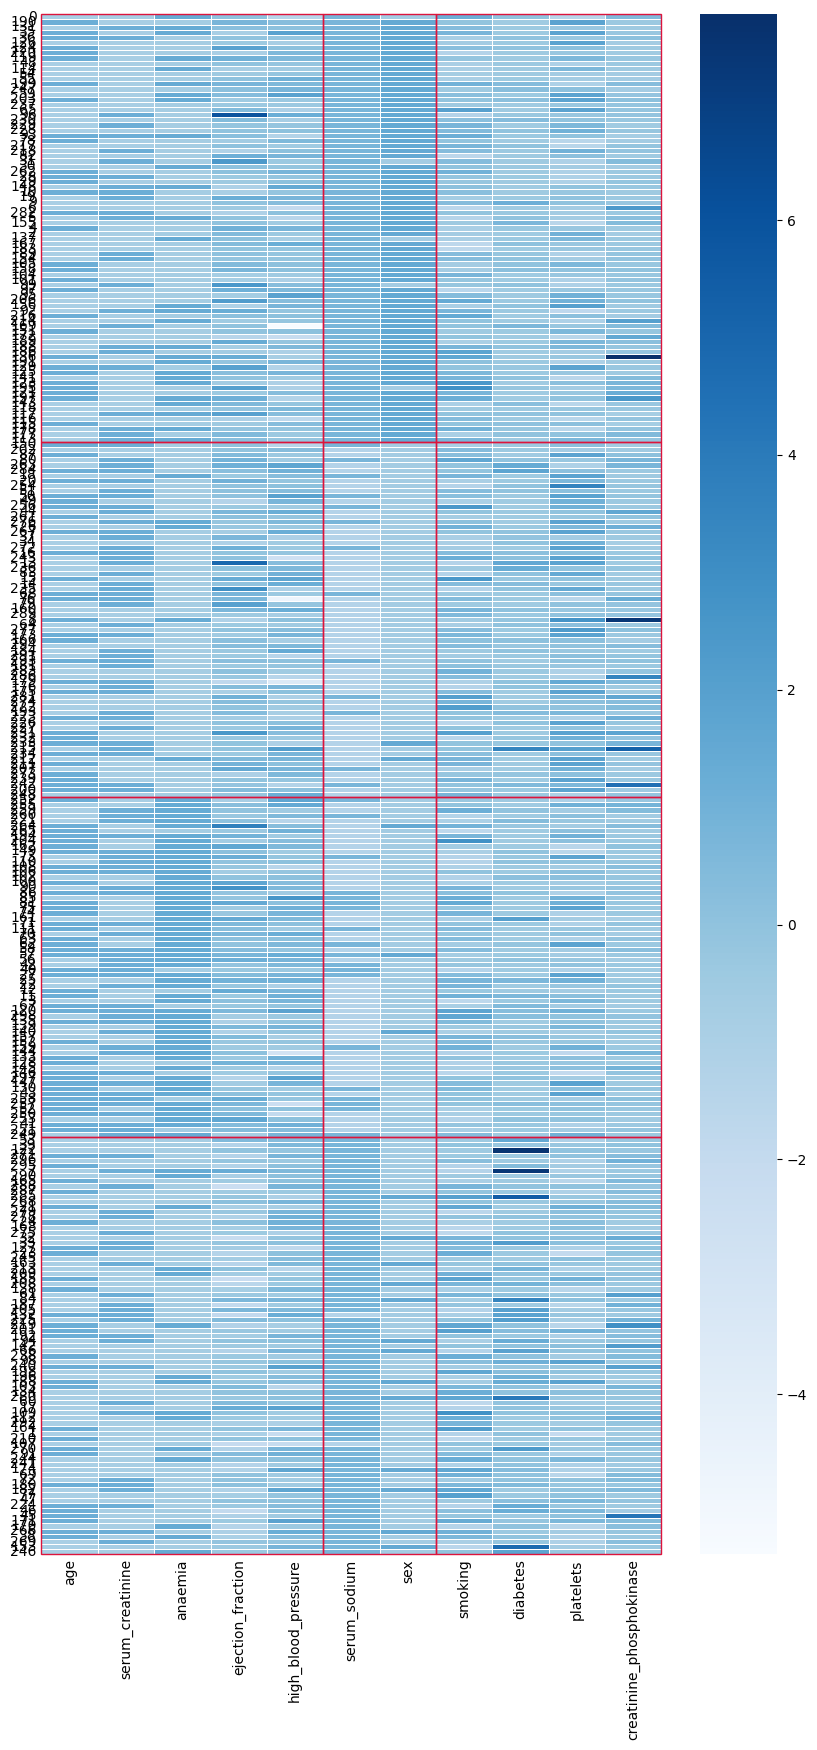

4 4


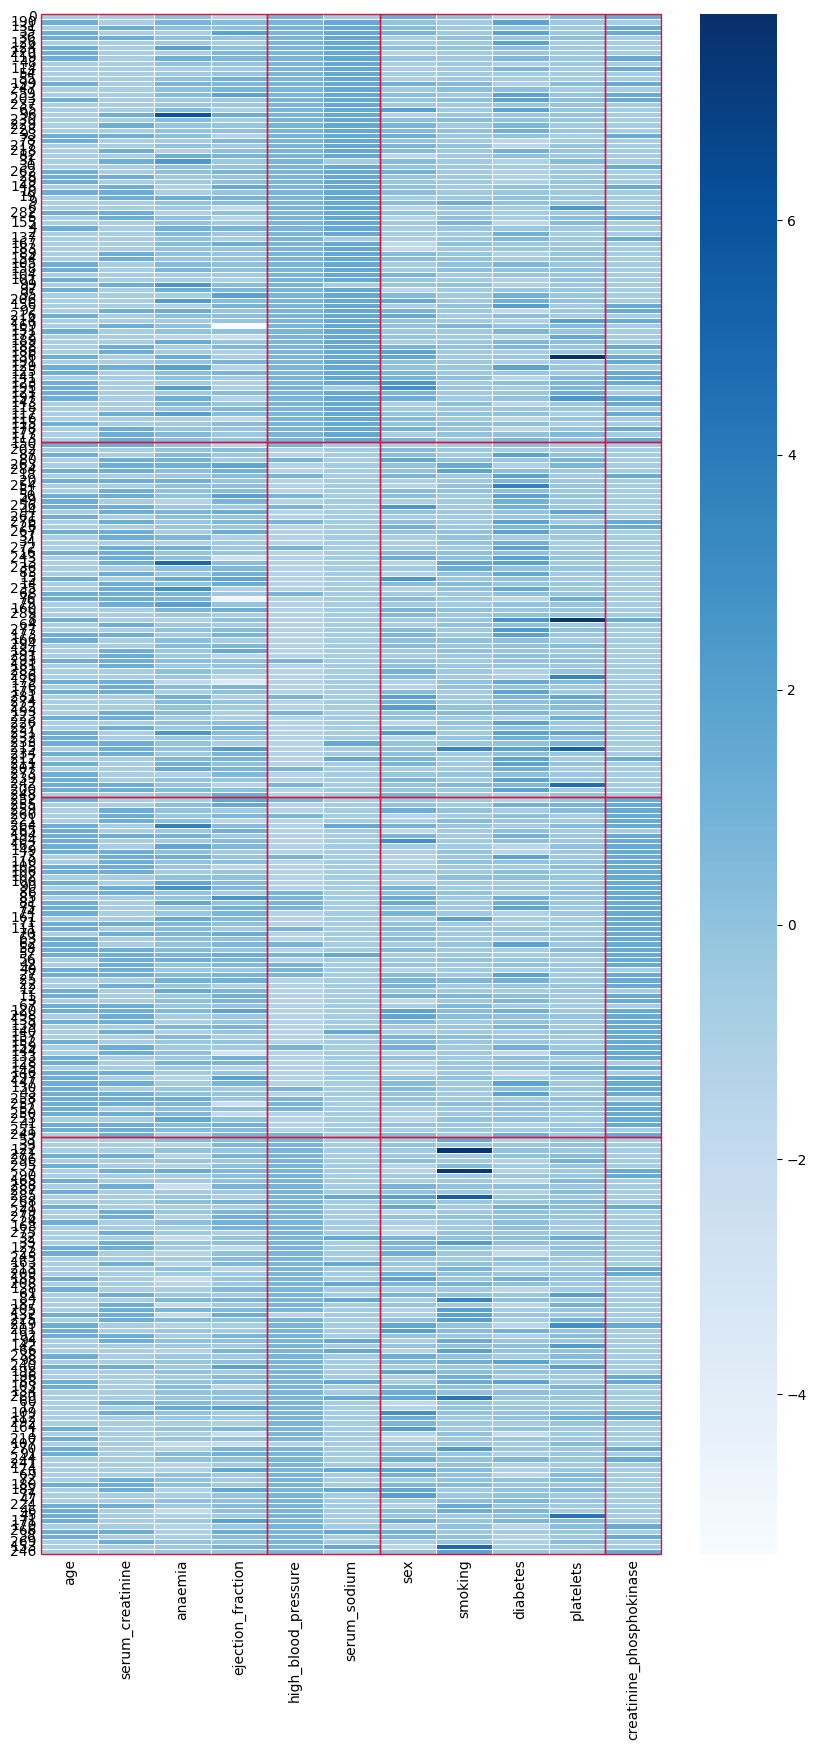

In [52]:
for a in range(4,5):
    for b in range(3,5):
        est_bicl=SpectralBiclustering(n_clusters=(a,b), random_state=0)
        est_bicl.fit(X)
        fit_bicl = X.values[np.argsort(est_bicl.row_labels_)]
        fit_bicl = fit_bicl[:, np.argsort(est_bicl.column_labels_)]
        fit_bicl = pd.DataFrame(fit_bicl, columns=X.columns[np.argsort(est_bicl.column_labels_)], index=X.index[np.argsort(est_bicl.row_labels_)])
        pos_w=[]
        pos_h=[]
        for i in range(len(est_bicl.biclusters_[0])):
            pos_w.append(sum(est_bicl.biclusters_[0][i]))
            pos_h.append(sum(est_bicl.biclusters_[1][i]))
        fig=plt.figure(figsize=(10,20))

        ax = sns.heatmap(fit_bicl, cmap='Blues', linewidths=.5,
                         xticklabels=fit_data.columns, yticklabels=fit_data.index)
        pos_y=0
        pos_x=0
        for i in range(est_bicl.n_clusters[0]):
            for j in range(est_bicl.n_clusters[1]):
                pos_h=len([np.argsort(est_bicl.row_labels_)[b]  for b in est_bicl.biclusters_[0]][j + est_bicl.n_clusters[1]*i])    
                pos_w=len([np.argsort(est_bicl.column_labels_)[b]  for b in est_bicl.biclusters_[1]][j + est_bicl.n_clusters[1]*i])    
                ax.add_patch(Rectangle((pos_x, pos_y), pos_w, pos_h, fill=False, edgecolor='crimson', lw=1, clip_on=False))
                pos_x+=pos_w
            pos_x=0
            pos_y+=pos_h

        ax.tick_params(length=0)
        #fig.savefig('biclust_{}_{}.png'.format(est.n_clusters[0], est.n_clusters[1]), bbox_inches='tight')
        #plt.close(fig)
        print(str(a)+" " + str(b))
        plt.show()

### SHAP

In [410]:
import shap
from xgboost import XGBClassifier


est = XGBClassifier()
est.fit(X, y)


# compute SHAP values
explainer = shap.Explainer(est)
shap_values = explainer(X)

In [411]:

clusters = []
shap_clusters = []

for i in range(est_cocl.n_clusters):    
    X_sub = X.iloc[list(np.where(est_cocl.row_labels_==i)[0])]
    y_sub = y[list(np.where(est_cocl.row_labels_==i)[0])]
    est = XGBClassifier()
    est.fit(X,y)
    shap_clusters.append(explainer(X_sub))
    

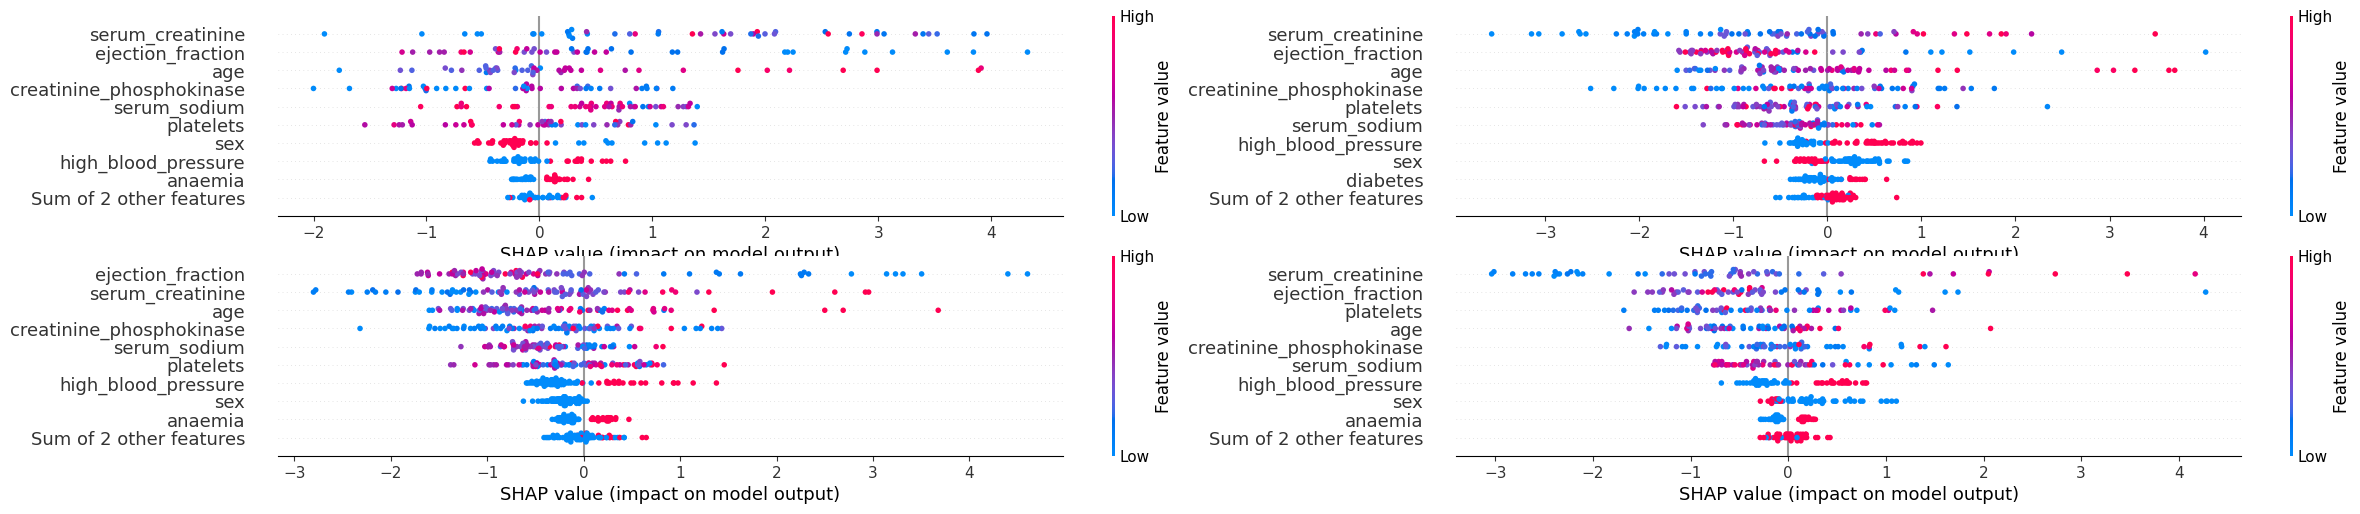

In [412]:
plt.figure(figsize=(40,20))
plt.subplot(2,2,1)
shap.plots.beeswarm(
    shap_clusters[0], max_display=10, show=False)

plt.subplot(2,2,2)
shap.plots.beeswarm(
    shap_clusters[1], max_display=10, show=False)


plt.subplot(2,2,3)
shap.plots.beeswarm(
    shap_clusters[2], max_display=10, show=False)


plt.subplot(2,2,4)
shap.plots.beeswarm(
    shap_clusters[3], max_display=10, show=False)


plt.subplots_adjust(
    left=0.8,
    bottom=0.2, 
    right=3.5, 
    top=1)


In [413]:

clusters = []
shap_clusters = []

for i in range(est_bicl.n_clusters[0]):    
    X_sub = X.iloc[list(np.where(est_bicl.row_labels_==i)[0])]
    y_sub = y[list(np.where(est_bicl.row_labels_==i)[0])]
    est = XGBClassifier()
    est.fit(X,y)
    shap_clusters.append(explainer(X_sub))
    

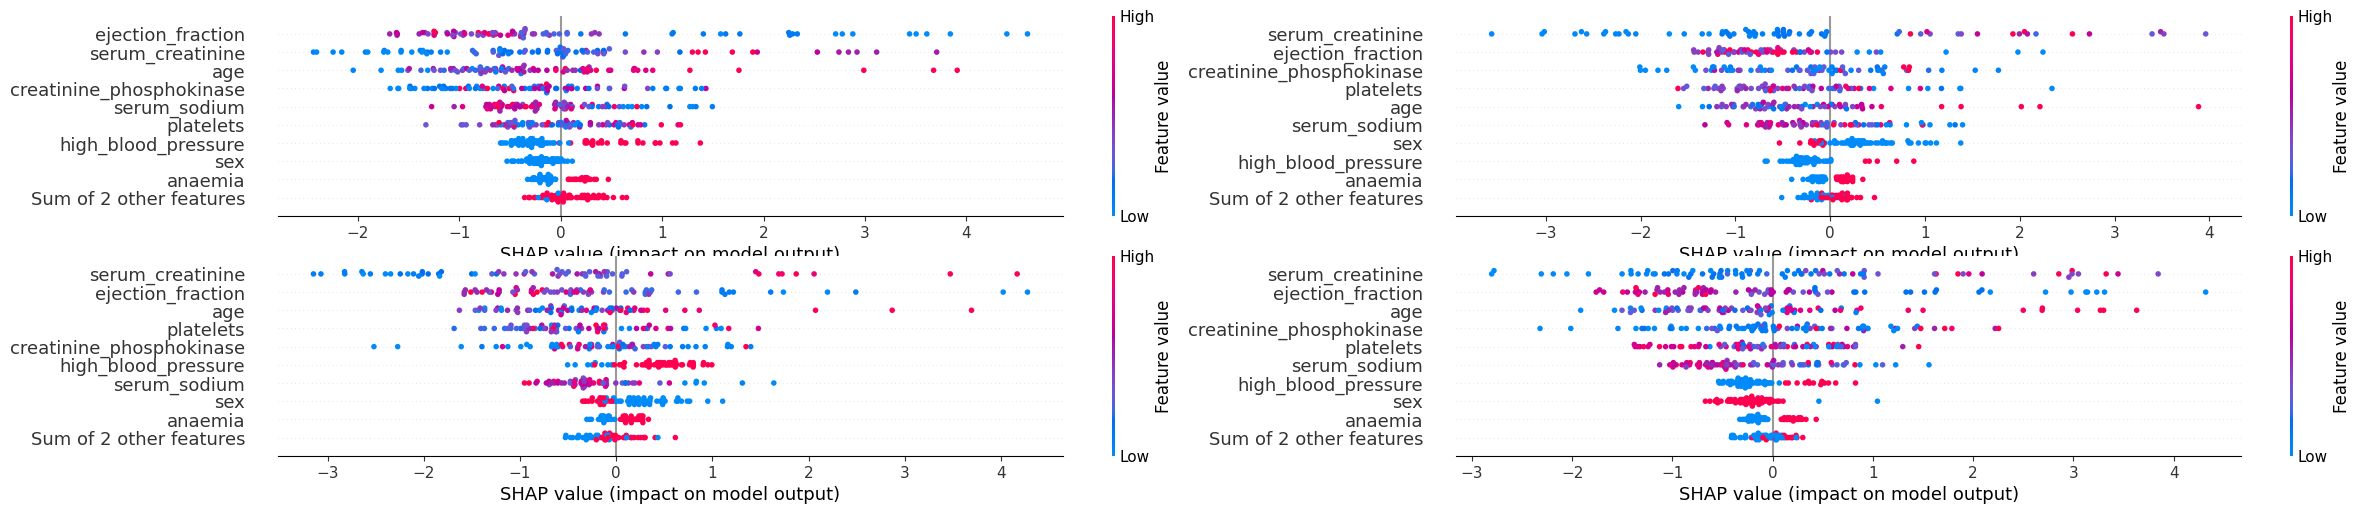

In [414]:
plt.figure(figsize=(40,20))
plt.subplot(2,2,1)
shap.plots.beeswarm(
    shap_clusters[0], max_display=10, show=False)

plt.subplot(2,2,2)
shap.plots.beeswarm(
    shap_clusters[1], max_display=10, show=False)


plt.subplot(2,2,3)
shap.plots.beeswarm(
    shap_clusters[2], max_display=10, show=False)


plt.subplot(2,2,4)
shap.plots.beeswarm(
    shap_clusters[3], max_display=10, show=False)


plt.subplots_adjust(
    left=0.8,
    bottom=0.2, 
    right=3.5, 
    top=1)


2 4


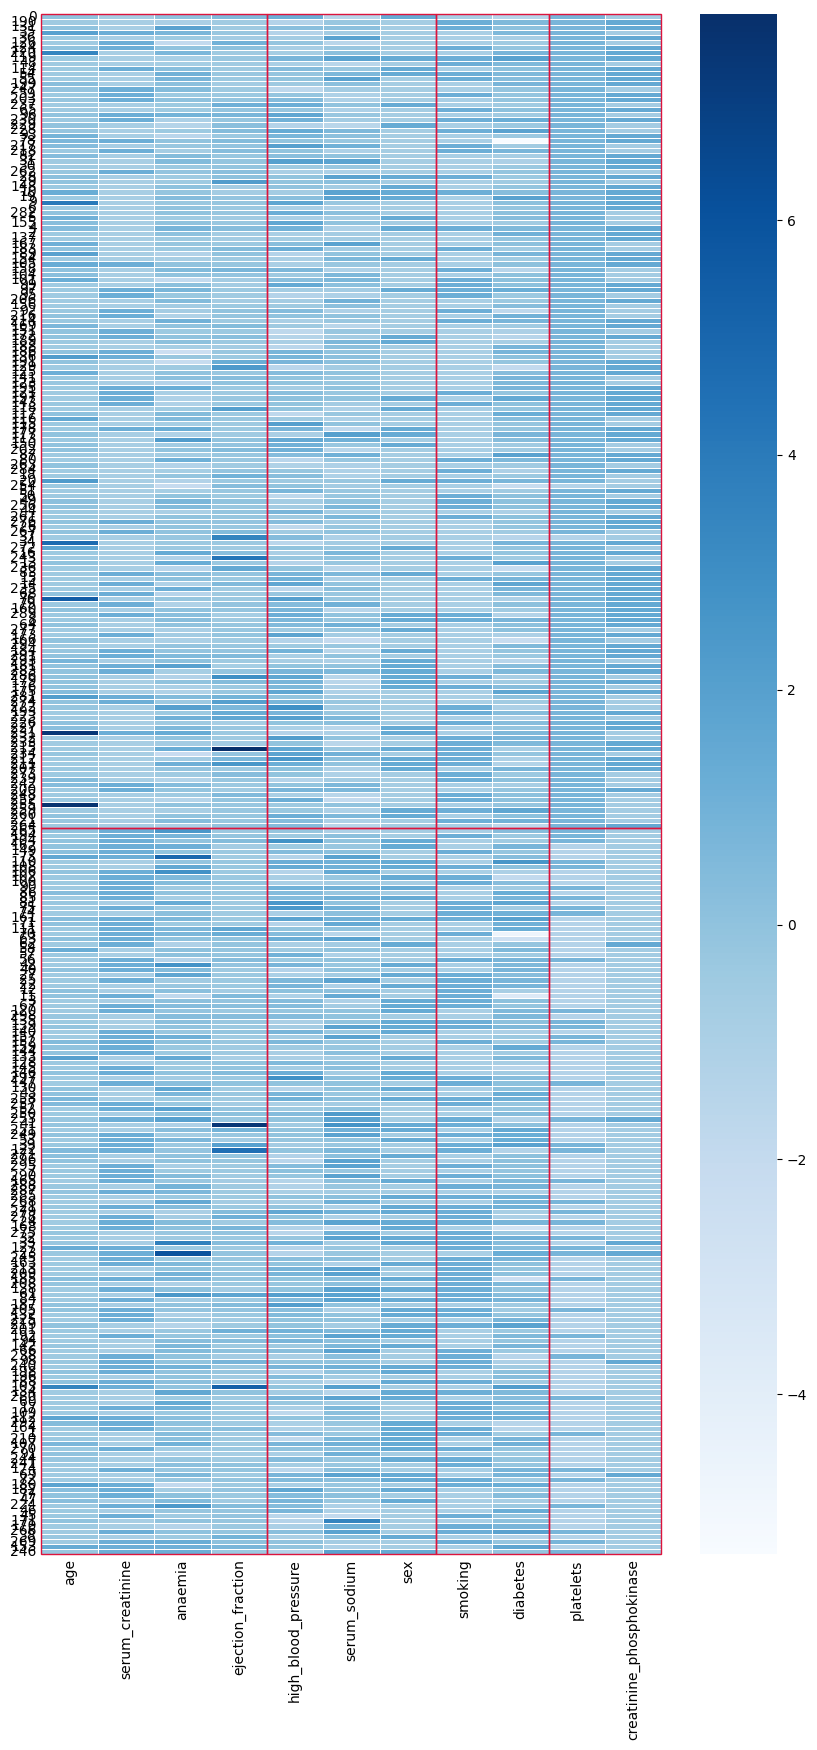

In [443]:
for a in range(2,3):
    for b in range(4,5):
        est_bicl=SpectralBiclustering(n_clusters=(a,b), random_state=0)
        est_bicl.fit(X)
        fit_bicl = X.values[np.argsort(est_bicl.row_labels_)]
        fit_bicl = fit_bicl[:, np.argsort(est_bicl.column_labels_)]
        fit_bicl = pd.DataFrame(fit_bicl, columns=X.columns[np.argsort(est_bicl.column_labels_)], index=X.index[np.argsort(est_bicl.row_labels_)])
        pos_w=[]
        pos_h=[]
        for i in range(len(est_bicl.biclusters_[0])):
            pos_w.append(sum(est_bicl.biclusters_[0][i]))
            pos_h.append(sum(est_bicl.biclusters_[1][i]))
        fig=plt.figure(figsize=(10,20))

        ax = sns.heatmap(fit_bicl, cmap='Blues', linewidths=.5,
                         xticklabels=fit_data.columns, yticklabels=fit_data.index)
        pos_y=0
        pos_x=0
        for i in range(est_bicl.n_clusters[0]):
            for j in range(est_bicl.n_clusters[1]):
                pos_h=len([np.argsort(est_bicl.row_labels_)[b]  for b in est_bicl.biclusters_[0]][j + est_bicl.n_clusters[1]*i])    
                pos_w=len([np.argsort(est_bicl.column_labels_)[b]  for b in est_bicl.biclusters_[1]][j + est_bicl.n_clusters[1]*i])    
                ax.add_patch(Rectangle((pos_x, pos_y), pos_w, pos_h, fill=False, edgecolor='crimson', lw=1, clip_on=False))
                pos_x+=pos_w
            pos_x=0
            pos_y+=pos_h

        ax.tick_params(length=0)
        #fig.savefig('biclust_{}_{}.png'.format(est.n_clusters[0], est.n_clusters[1]), bbox_inches='tight')
        #plt.close(fig)
        print(str(a)+" " + str(b))
        plt.show()

In [444]:
est_bicl.row_labels_

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [445]:
#other metrics require mapping between values

from sklearn.metrics.cluster import contingency_matrix
mapping = dict(zip(range(len(Counter(est_bicl.row_labels_))), np.argmax(contingency_matrix(y,est_bicl.row_labels_), axis=1)))
y_pred = np.vectorize(mapping.get)(est_bicl.row_labels_)
balanced_accuracy_score(y, y_pred), adjusted_rand_score(est_bicl.row_labels_, y)  #rand index is symmetric

(0.5, -0.0008164530928857129)

In [446]:
est_bicl.row_labels_

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [447]:
np.array(y)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtyp

### Shared Nearest Neighbors

In [448]:
#https://github.com/albert-espin/snn-clustering/blob/master/SNN/snn.py

In [449]:
from snn import SNN

In [438]:
params={
        'neighbor_num': 25,
        'min_shared_neighbor_proportion': 0.5,
    }

In [439]:
clustering=SNN(**params)
clustering.fit(X.values)
num_clusters = len(Counter(clustering.labels_))-1

In [440]:
clustering.labels_

array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0, -1, -1,  0, -1,  0,
       -1, -1,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1,  0, -1, -1, -1,  0,  0,  1, -1, -1,  0, -1,  1, -1,
       -1,  0, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0, -1, -1, -1

In [441]:
clusters = []
shap_values = []
est = XGBClassifier()
est.fit(X,y)

def most_frequent(l):
     return max(set(l), key=l.count)



for i in range(num_clusters):
    X_sub = X.iloc[list(np.where(clustering.labels_==i)[0])]
    y_sub = y[list(np.where(clustering.labels_==i)[0])]
    print(Counter(y_sub))
    shap_values.append(explainer(X_sub))
    
    y_sub[y_sub.index] = most_frequent(list(y_sub))


Counter({0: 38, 1: 8})
Counter({0: 12, 1: 3})


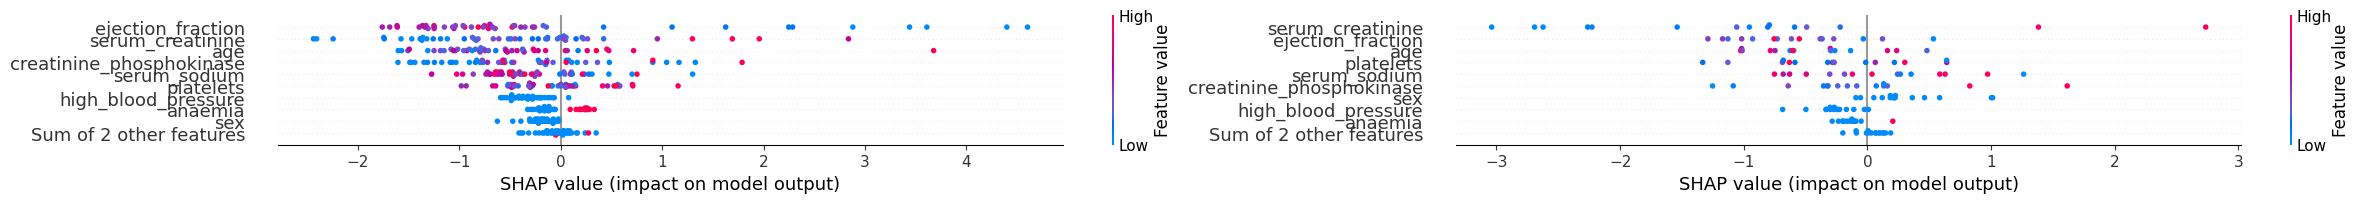

In [442]:
plt.figure(figsize=(40,20))
plt.subplot(3,2,1)
shap.plots.beeswarm(
    shap_values[0], max_display=10, show=False)

plt.subplot(3,2,2)
shap.plots.beeswarm(
    shap_values[1], max_display=10, show=False)



plt.subplots_adjust(
    left=0.8,
    bottom=0.2, 
    right=3.5, 
    top=1)
